In [3]:
import os
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np
np.float_ = np.float64
from prophet import Prophet
SHOW_PREDICT = True
TICKERS = {"^GSPC":"S&P500", "^BSESN":"SENSEX", "^N225": "N225"}

def showFiveYearsChart(ticker="^GSPC"):
    # prep
    os.makedirs(TICKERS[ticker], exist_ok=True)

    # S&P 500のデータを取得
    raw_data = yf.Ticker(ticker)
    start_date = "2018-01-01"
    end_date = datetime.now().strftime("%Y-%m-%d")
    data = raw_data.history(start=start_date, end=end_date)

    # 想定値の計算
    current_date = data.index[-1]
    current_price = data['Close'].iloc[-1]

    # Prophetが要求するフォーマットにデータを変換
    df = data.reset_index()[["Date", "Close"]]
    df.columns = ["ds", "y"]
    df['ds'] = df['ds'].dt.tz_localize(None)

    # Prophetモデルの初期化と学習
    model = Prophet(daily_seasonality=True)
    model.fit(df)

    # 将来の日付を生成し、予測を実行
    future_dates = model.make_future_dataframe(periods=365)
    forecast = model.predict(future_dates)

    # 将来の想定値を設定
    target_date = datetime(data.index[-1].year, 12, 31)  # 想定値を達成する将来の日を指定します（例: 2024年12月31日）
    target_price = forecast[forecast['ds'] == target_date.strftime("%Y-%m-%d")].yhat.values[0]

    # 想定値の推移を計算
    target_date = target_date.replace(tzinfo=current_date.tzinfo)
    days_to_target = (target_date - current_date).days
    daily_growth_rate = (target_price / current_price) ** (1 / days_to_target) - 1
    future_dates = pd.date_range(start=current_date + timedelta(days=1), end=target_date, freq='B')
    future_prices = [current_price * (1 + daily_growth_rate) ** i for i in range(1, len(future_dates) + 1)]
    future_data = pd.Series(future_prices, index=future_dates)

    # 各年の最初の取引日の終値を100%として正規化
    yearly_data = {}
    last_year = datetime.now().year
    for year in range(2018, last_year + 1):
        if year == last_year:
            year_data = pd.concat([data[data.index.year == last_year]['Close'], future_data])
        else:
            year_data = data[data.index.year == year]['Close']
        if not year_data.empty:
            base_value = year_data.iloc[0]
            yearly_data[year] = (year_data / base_value) * 100

    print('current_date: ' + str(current_date))
    print('current_price: ' + str(current_price))
    print('target_date: ' + str(target_date))
    print('target_price: ' + str(target_price))
    print("Predicted performance: " + str(target_price/data[data.index.year == last_year]['Close'][0]*100-100))

    str_now = datetime.now().strftime("%Y/%m/%d %H:%M")
    plt.figure(figsize=(15, 10))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#e377c2', '#9467bd', '#8c564b', '#d62728']
    fig_title = TICKERS[ticker] + ' (data requested on ' + str_now + ')'

    for i, (year, values) in enumerate(yearly_data.items()):
        if year == datetime.now().year:
            _l = len(data[data.index.year == last_year]['Close'])
            plt.plot(values.index.dayofyear[0:_l], values[0:_l], label=str(year), color=colors[-1], linewidth=5)
            if SHOW_PREDICT:
                plt.plot(values.index.dayofyear[_l:], values[_l:], label=str(year), color=colors[-1], linewidth=3, linestyle=':')
        else:
            plt.plot(values.index.dayofyear, values, label=str(year), color=colors[i % len(colors)])

    plt.legend(title='YEAR', fontsize=10, loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xlim(1, 366)
    plt.ylim(60, 135)

    plt.xticks([1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335, 366],
            ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''])

    plt.ylabel('Relative performance from January 1st [%]', fontsize=12)
    plt.title(fig_title, fontsize=12)

    plt.tight_layout()
    plt.savefig(TICKERS[ticker] + "/" + datetime.now().strftime("%Y-%m-%d") + ".png", format="png", dpi=300)
    plt.show()


10:01:38 - cmdstanpy - INFO - Chain [1] start processing
10:01:38 - cmdstanpy - INFO - Chain [1] done processing


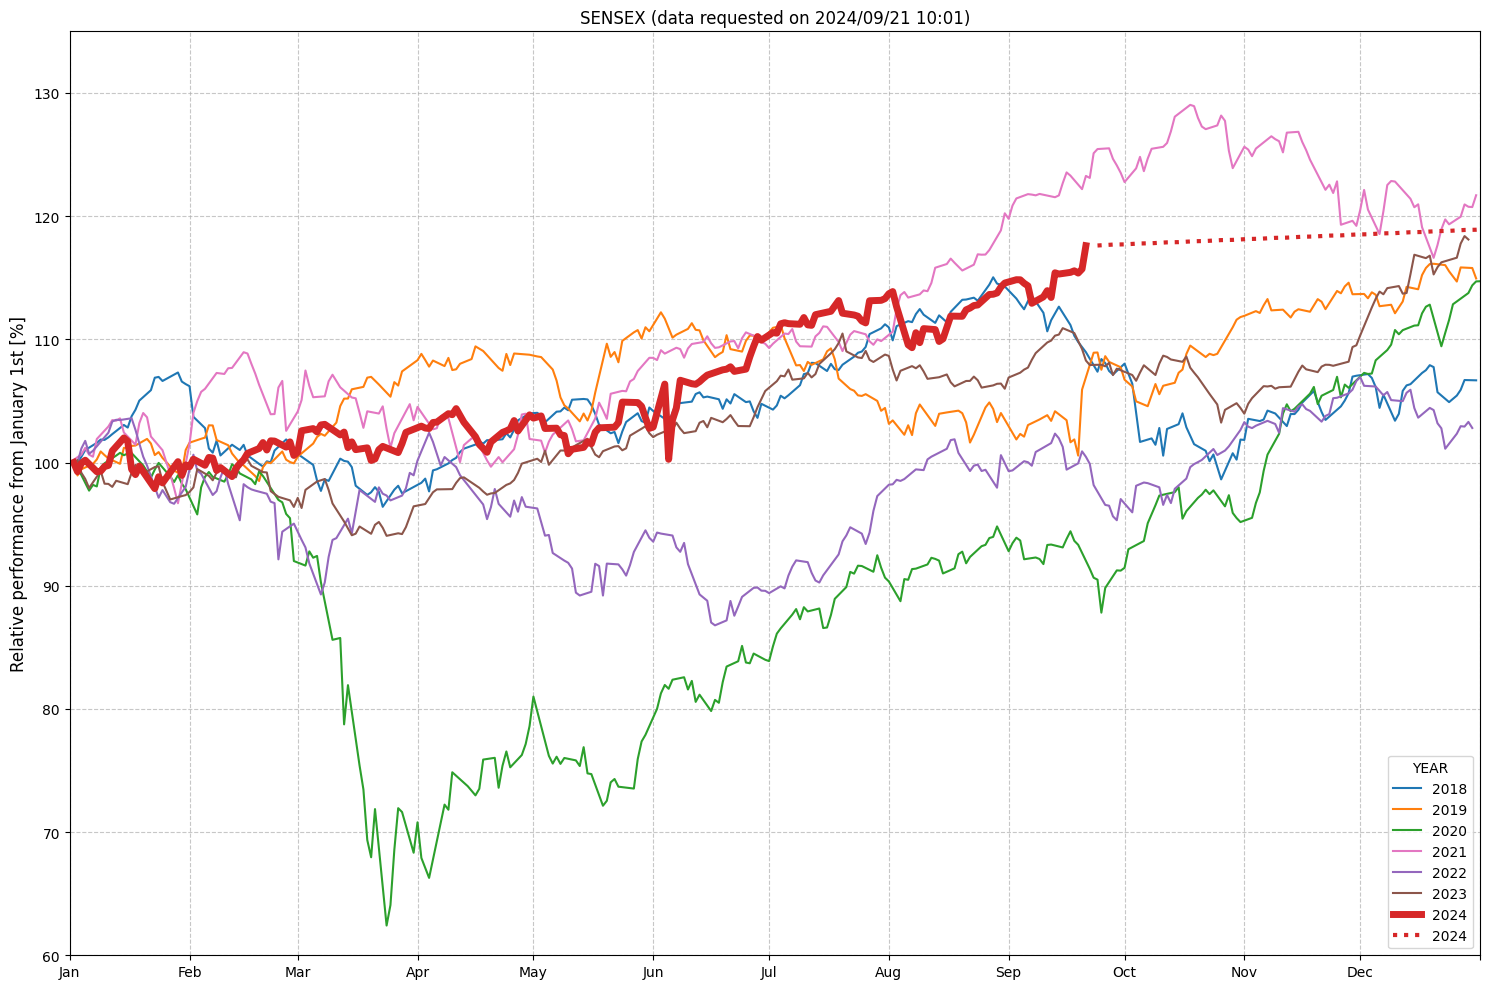

current_date: 2024-09-20 00:00:00+05:30
current_price: 84544.3125
target_date: 2024-12-31 00:00:00+05:30
target_price: 85886.2863551102
Predicted performance: 19.464915470598143


/var/folders/y7/_3lfw6vj0mbb35lymf41vk3w0000gn/T/ipykernel_36195/128840239.py:96: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Predicted performance: " + str(target_price/data[data.index.year == last_year]['Close'][0]*100-100))


In [4]:
showFiveYearsChart(ticker="^BSESN")